# NYPD Crime Reports Dataset

You are asked to analyze the dataset with all the valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 to the end of last year (2016). 

The dataset is available at:
https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i

It is a big dataset with ~5.5 million crimes reported to NYPD. 

## Attribute Description

Below you can find the description of the attributes, and their datatypes. 

| Column | Description | Data Type
|--------|-------------------|----|
| CMPLNT_NUM | Randomly generated persistent ID for each complaint  | bigint(20) |
| CMPLNT_FR | Exact datetime of occurrence for the reported event (or starting date of occurrence, if CMPLNT_TO_DT exists) | datetime |
| CMPLNT_TO | Ending datetime of occurrence for the reported event, if exact time of occurrence is unknown | datetime
| RPT_DT | Date event was reported to police  | date
| KY_CD | Three digit offense classification code | char(3)
| OFNS_DESC | Description of offense corresponding with key code | varchar(80)
| PD_CD | Three digit internal classification code (more granular than Key Code) | char(3)
| PD_DESC | Description of internal classification corresponding with PD code (more granular than Offense Description) | varchar(60)
| CRM_ATPT_CPTD_CD | Indicator of whether crime was successfully completed or attempted, but failed or was interrupted prematurely | enum('COMPLETED','ATTEMPTED')
| LAW_CAT_CD | Level of offense: felony, misdemeanor, violation  | enum('FELONY','MISDEMEANOR','VIOLATION')
| JURIS_DESC | Jurisdiction responsible for incident. Either internal, like Police, Transit, and Housing; or external, like Correction, Port Authority, etc. | varchar(80)
| BORO_NM | The name of the borough in which the incident occurred | varchar(20)
| ADDR_PCT_CD | The precinct in which the incident occurred | char(3)
| LOC_OF_OCCUR_DESC | Specific location of occurrence in or around the premises; inside, opposite of, front of, rear of | enum('FRONT OF','INSIDE','OPPOSITE OF','OUTSIDE','REAR OF')
| PREM_TYP_DESC | Specific description of premises; grocery store, residence, street, etc. | varchar(80)
| PARKS_NM | Name of NYC park, playground or greenspace of occurrence, if applicable (state parks are not included) | varchar(80)
| HADEVELOPT | Name of NYCHA housing development of occurrence, if applicable | varchar(80)
| X_COORD_CD | X-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104) | char(9)
| Y_COORD_CD | Y-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104) | char(9)
| Latitude | Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)  | double
| Longitude | Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326) | double

Additional Notes: https://www1.nyc.gov/assets/nypd/downloads/pdf/analysis_and_planning/incident_level_data_footnotes.pdf

## MySQL Database

For your convenience, the dataset is stored in the `nypd_complaints` database on the MySQL Server `db.ipeirotis.org`. You can connect and see the dataset using your standard username and password (`student`, `dwdstudent2015`). 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from sqlalchemy import create_engine
import geopandas as gpd
import seaborn as sns
import matplotlib as plt


In [2]:
conn_string = 'mysql://{user}:{password}@{host}:{port}/{db}?charset={encoding}'.format(
    user='student', 
    password='dwdstudent2015', 
    host = 'db.ipeirotis.org', 
    port=3306, 
    db='nypd_complaints',
    encoding = 'utf8'
)
engine = create_engine(conn_string)

# Questions

You are asked to analyze the dataset and provide answers for the questions below. You can answer the questions using Python, SQL, or a combination of them. 

## Question 1: Composition of crimes

* **Question 1a**: How many total reported crimes are in the dataset?
* **Question 1b**: Analyze the column `LAW_CAT_CD` and provide the breakdown of the reported crimes among `FELONY`,`MISDEMEANOR`, and `VIOLATION`, i.e., report the number of felonies, misdemeanors, and violations.
* **Question 1c**: Across **felonies**, report the number of crimes, broken down by  offense description (as reported in the `OFNS_DESC` column)

In [3]:
# Question 1a: How many total reported crimes are in the dataset?
query ='''
SELECT COUNT(*)
FROM nypd
'''
engine.execute(query).fetchall()[0][0]

5580035

In [4]:
# Question 1b: Analyze the column LAW_CAT_CD and report the number of felonies, misdemeanors, and violations.
query = '''
SELECT LAW_CAT_CD, COUNT(*) AS total
FROM nypd
WHERE LAW_CAT_CD IN ("FELONY","MISDEMEANOR","VIOLATION")
GROUP BY LAW_CAT_CD
ORDER BY total DESC;
'''
df = pd.read_sql(query, con=engine)
df

,LAW_CAT_CD,total
0,MISDEMEANOR,3180644
1,FELONY,1717265
2,VIOLATION,682126


In [5]:
# Question 1c: Across felonies, report the number of crimes, broken down by offense description (as reported in the OFNS_DESC column)
query = '''
SELECT OFNS_DESC, COUNT(*) AS total
FROM nypd
WHERE LAW_CAT_CD LIKE "FELONY"
GROUP BY OFNS_DESC
ORDER BY total DESC;
'''
df = pd.read_sql(query, con=engine)
df

,OFNS_DESC,total
0,GRAND LARCENY,473457
1,ROBBERY,214271
2,FELONY ASSAULT,204904
3,BURGLARY,204396
4,MISCELLANEOUS PENAL LAW,123576
5,GRAND LARCENY OF MOTOR VEHICLE,108387
6,CRIMINAL MISCHIEF & RELATED OF,82378
7,DANGEROUS DRUGS,67426
8,THEFT-FRAUD,61557
9,DANGEROUS WEAPONS,56027


## Question 2: Is crime increasing or decreasing in NYC?

Use the column `CMPLNT_FR` that reports the date/time of the crime. You are asked to analyze the crimes that happened between January 1st 2006 and December 31st 2016. 

* **Question 2a**: Create a plot that shows the *total* number of **all** reported crimes *per month*.
* **Question 2b**: Create a plot that shows the *total* number of **all** reported crimes *per year*.
* **Question 2c**: Create a plot that shows the *total* number of reported **felonies** *per month*.
* **Question 2d**: Create a plot that shows the *total* number of reported **felonies** *per year*.

**Hint 1**: Be aware that comparisons with dates in MySQL are tricky. You will want to use the format `2006-01-01` for a date, so that it gets properly interpreted by MySQL.

**Hint 2**: You can use the `MONTH()` and `YEAR()` commands in SQL, or the  `resample` command in Pandas, to compute statistics on a per-month and per-year basis. If you use resample, understand the difference between `resample(...).sum()` and `resample(...).mean()`. The `mean()` vs `sum()` can generate very different results, especially when the timestamp variable has a very fine granularity (as happens in our case with `CMPLNT_FR`).

In [7]:
plt.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
plt.rcParams['figure.figsize'] = (15, 7)

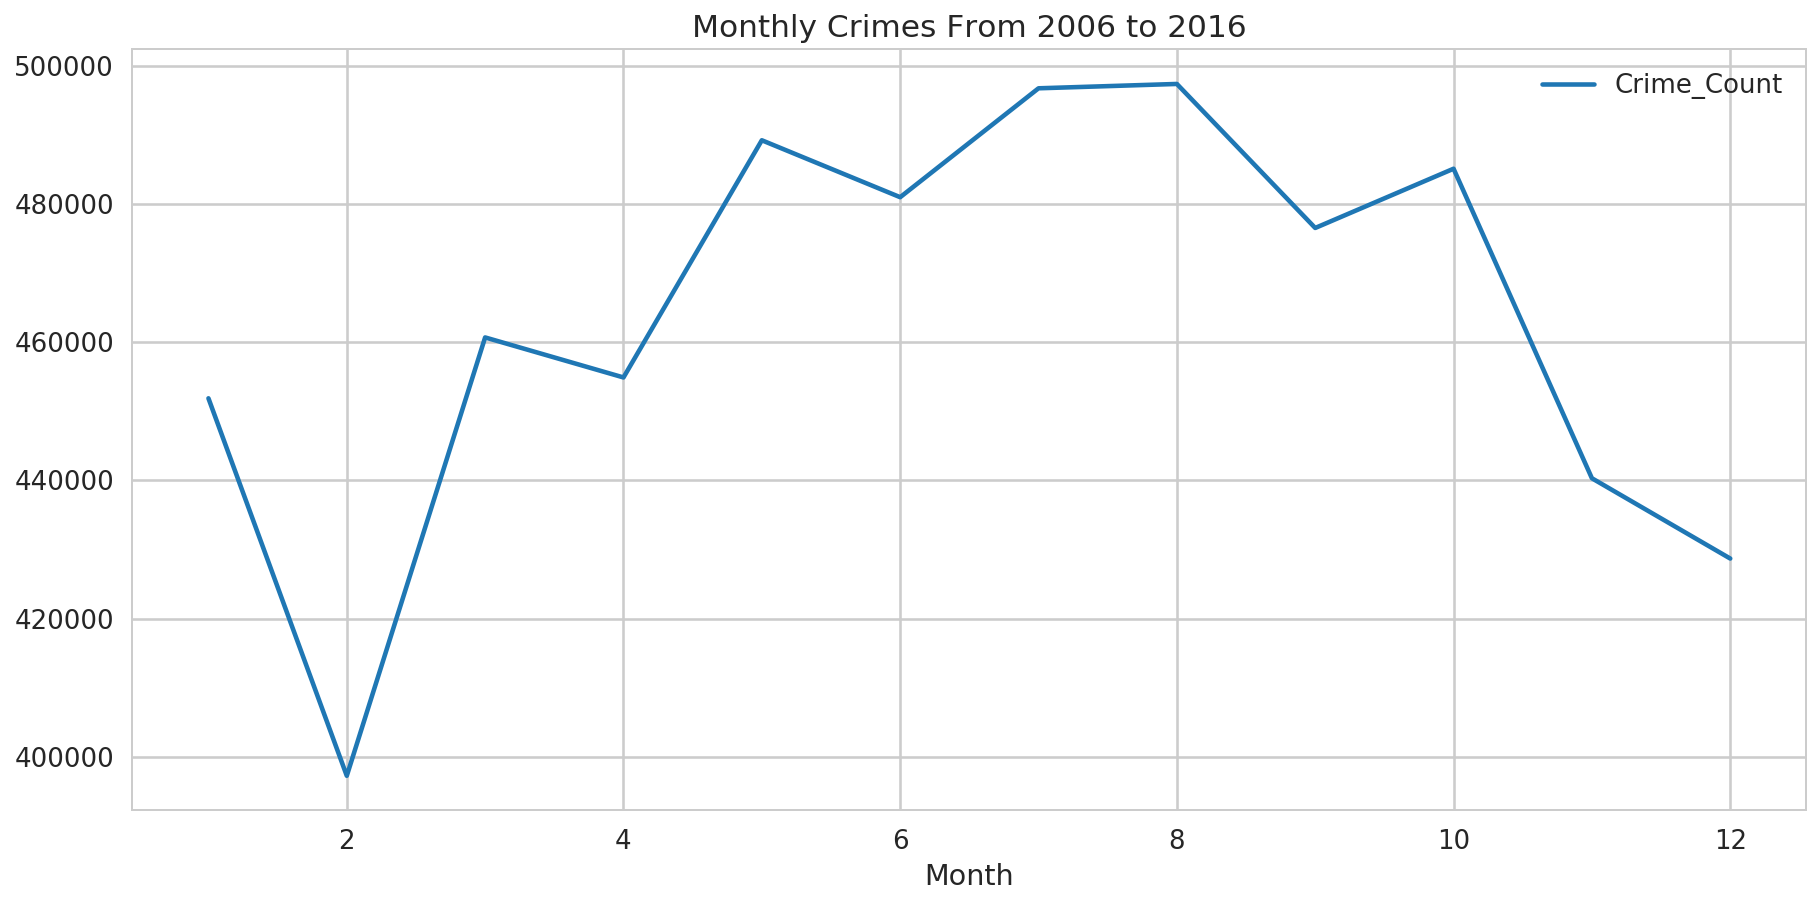

In [8]:
# Question 2a: Create a plot that shows the total number of all reported crimes per month.
query = '''
SELECT MONTH(CMPLNT_FR) AS Month, COUNT(*) AS Crime_Count
FROM nypd
WHERE CMPLNT_FR > "2006-01-01"
  AND CMPLNT_FR < "2016-12-31"
GROUP BY Month
ORDER BY Month
'''
df = pd.read_sql(query, con=engine)
df.plot(kind="Line",x="Month",y="Crime_Count",title="Monthly Crimes From 2006 to 2016")

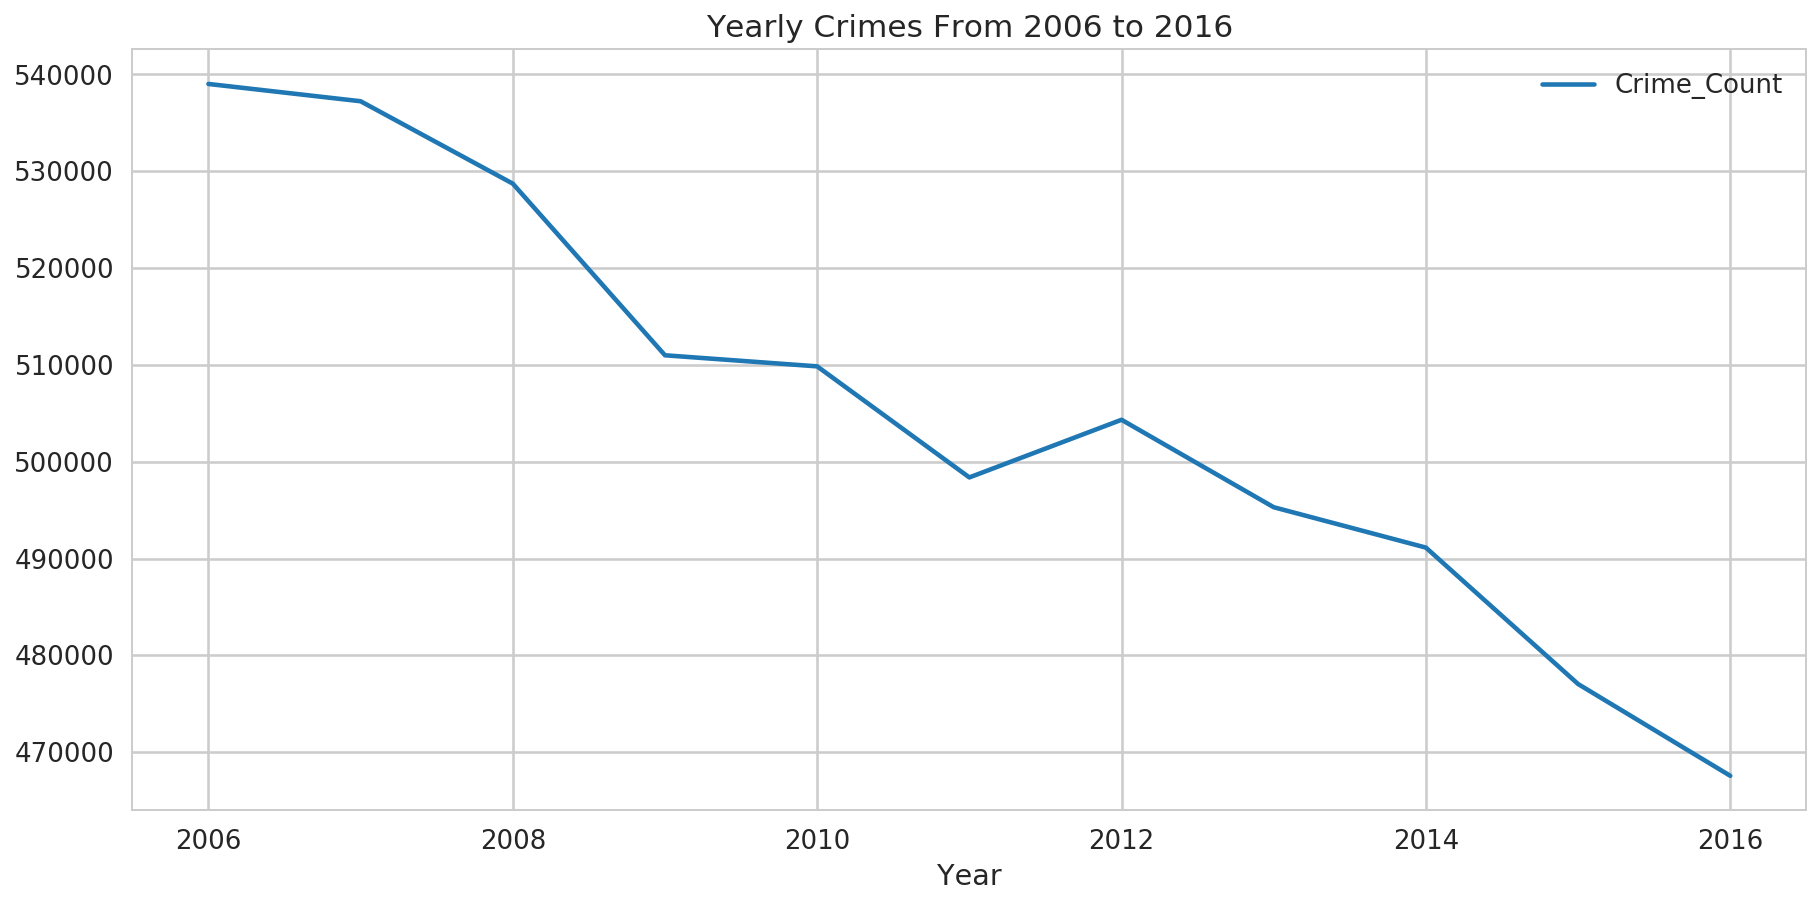

In [9]:
# Question 2b: Create a plot that shows the total number of all reported crimes per year.
query = '''
SELECT YEAR(CMPLNT_FR) AS Year, COUNT(*) AS Crime_Count
FROM nypd
WHERE CMPLNT_FR > "2006-01-01"
  AND CMPLNT_FR < "2016-12-31"
GROUP BY Year
ORDER BY Year
'''
df = pd.read_sql(query, con=engine)
df.plot(kind="Line",x="Year",y="Crime_Count",title="Yearly Crimes From 2006 to 2016")

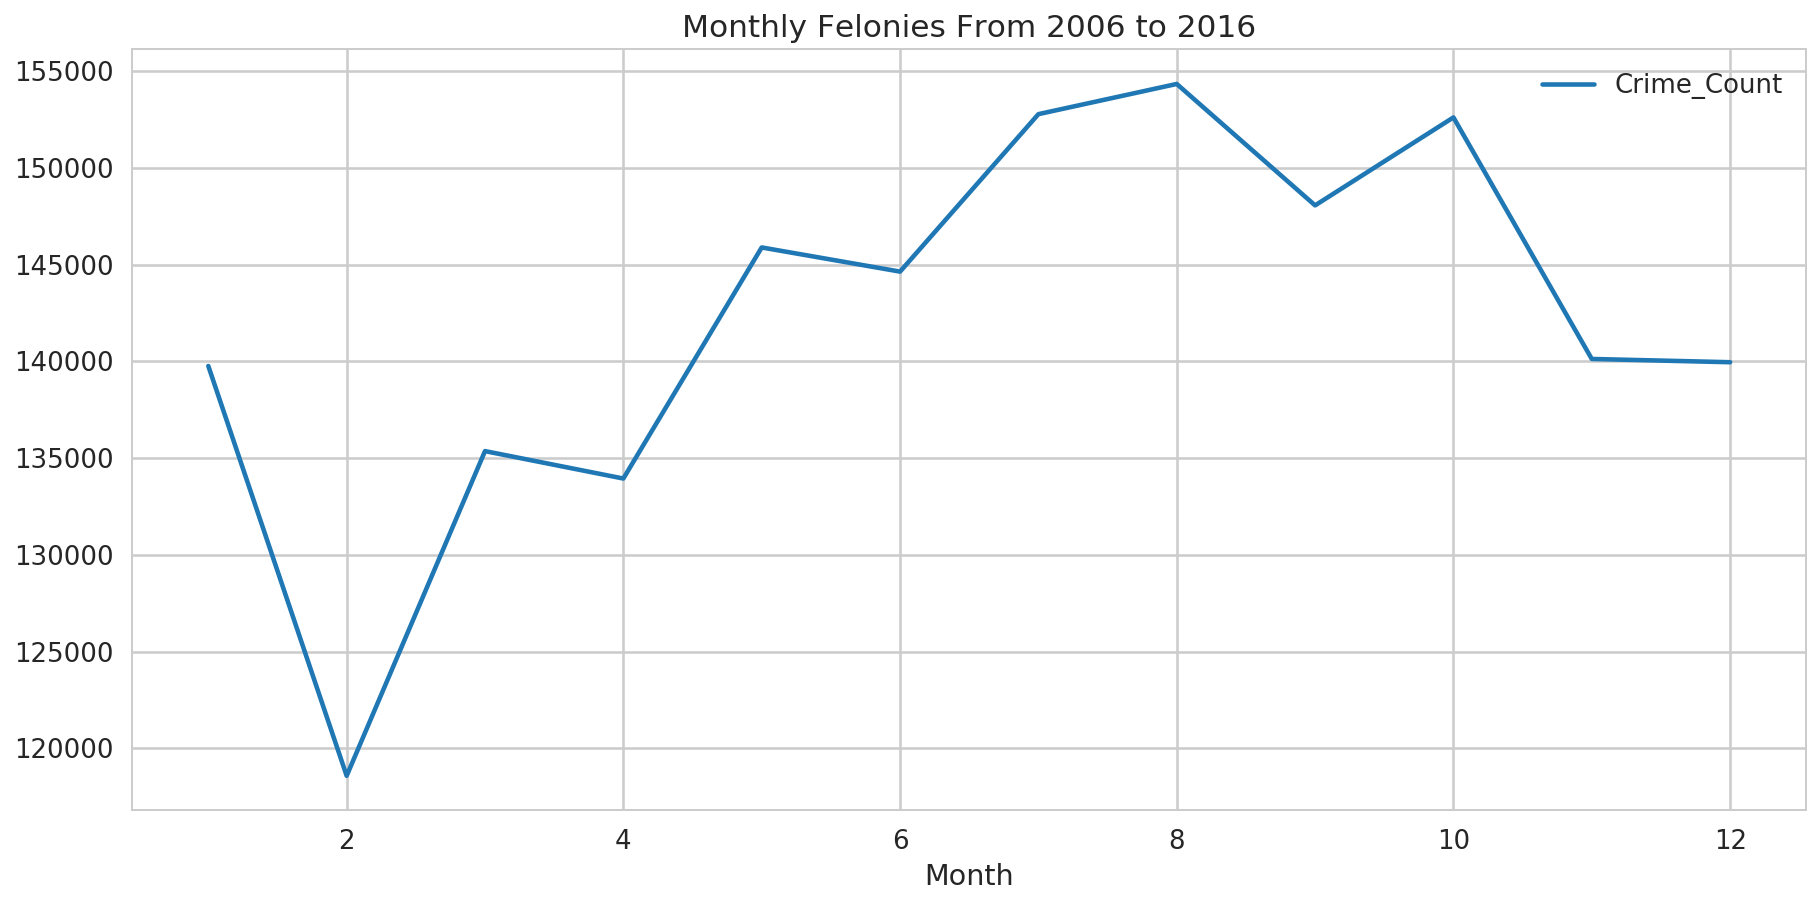

In [10]:
# Question 2c: Create a plot that shows the total number of reported felonies per month.
query = '''
SELECT MONTH(CMPLNT_FR) AS Month, COUNT(*) AS Crime_Count
FROM nypd
WHERE CMPLNT_FR > "2006-01-01"
  AND CMPLNT_FR < "2016-12-31"
  AND LAW_CAT_CD LIKE "FELONY"
GROUP BY Month
ORDER BY Month
'''
df = pd.read_sql(query, con=engine)
df.head()
df.plot(kind="Line",x="Month",y="Crime_Count",title="Monthly Felonies From 2006 to 2016")

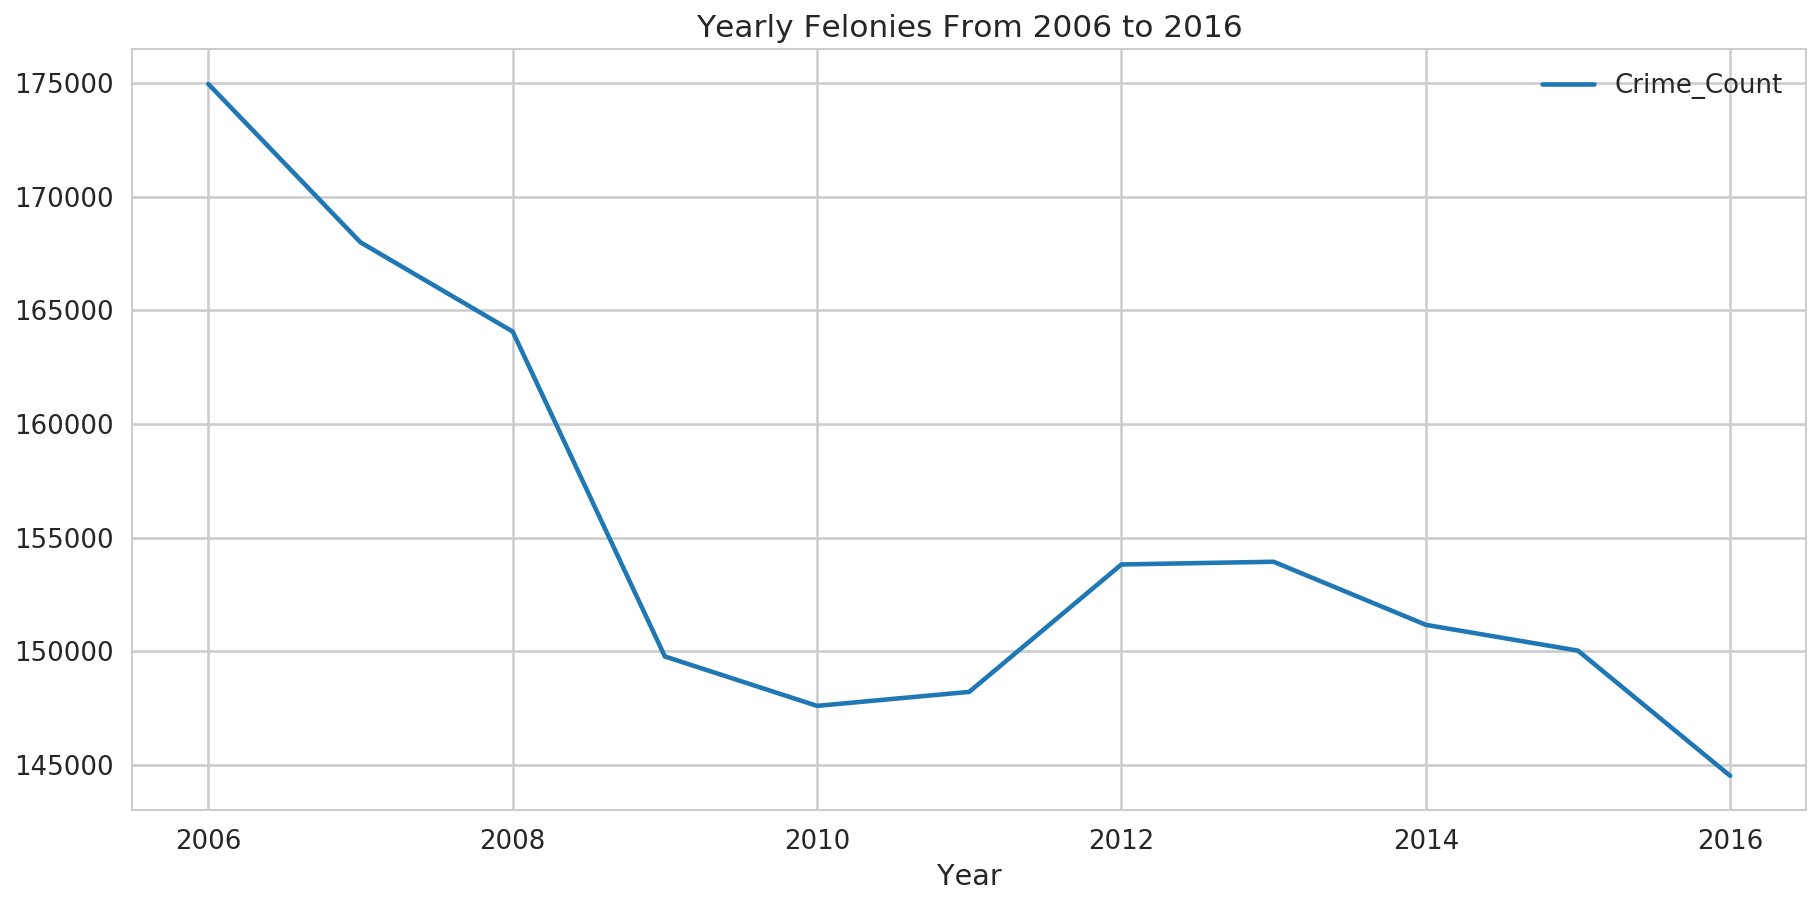

In [11]:
# Question 2d: Create a plot that shows the total number of reported felonies per year.10,5))
query = '''
SELECT YEAR(CMPLNT_FR) AS Year, COUNT(*) AS Crime_Count
FROM nypd
WHERE CMPLNT_FR > "2006-01-01"
  AND CMPLNT_FR < "2016-12-31"
  AND LAW_CAT_CD LIKE "FELONY"
GROUP BY Year
ORDER BY Year
'''
df = pd.read_sql(query, con=engine)
df.plot(kind="Line",x="Year",y="Crime_Count",title="Yearly Felonies From 2006 to 2016")

## Question 3: Analysis of the "Big-7" felonies

The NYPD calls the following types of felonies as the "big-7" crimes, as they tend to affect most the quality of life:

* GRAND LARCENY 
* ROBBERY 
* FELONY ASSAULT 
* BURGLARY 
* GRAND LARCENY OF MOTOR VEHICLE 
* RAPE 
* MURDER & NON-NEGL. MANSLAUGHTER 


Focus on the big-7 felonies. Report the number of these crimes over time, from 2006 till 2016, **broken down by type of felony**. Focus on reporting the **total** number of crimes per category, on a **per month** and on **per year** basis. Generate the associated plot.

**Hint 1**: The type of felony is included in the `OFNS_DESC` column. You can use the `IN` command in SQL to limit your results to these offenses, or use an `OR` clause. Alternatively, you can use the [`.isin()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.isin.html) command in Pandas.

**Hint 2**: If you would like to move the legend outside the plot, you can use the following command: `df.plot(...).legend(bbox_to_anchor=(1, 0.75))`. The two values for the parameter `bbox_to_anchor` describe the x/y location of the legend, compared to the plot. Experiment with different values to understand the effect.


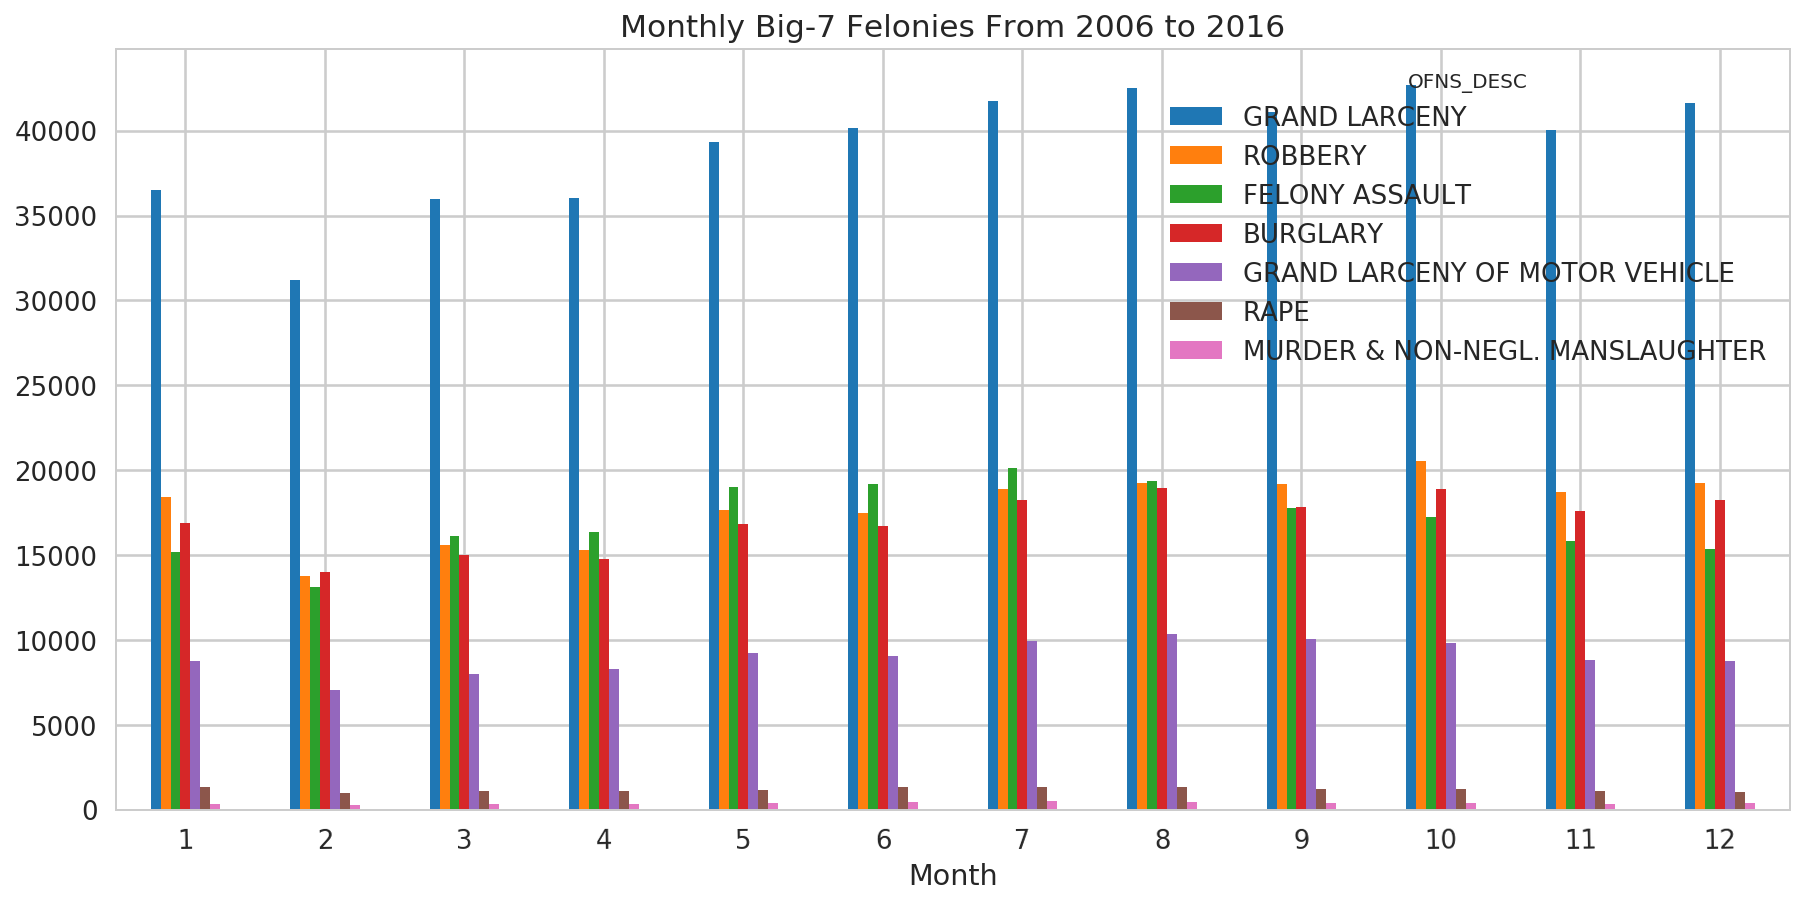

In [12]:
# Question 3a: Plot of big-7 felonies over time, monthly numbers
query = '''
SELECT MONTH(CMPLNT_FR) AS Month, OFNS_DESC, COUNT(*) AS Crime_Count
FROM nypd
WHERE CMPLNT_FR > "2006-01-01"
  AND CMPLNT_FR < "2016-12-31"
  AND OFNS_DESC IN ("GRAND LARCENY","ROBBERY","FELONY ASSAULT","BURGLARY","GRAND LARCENY OF MOTOR VEHICLE","RAPE","MURDER & NON-NEGL. MANSLAUGHTER")
GROUP BY Month,OFNS_DESC
ORDER BY Month
'''
df = pd.read_sql(query, con=engine)
df.OFNS_DESC = pd.Categorical(df.OFNS_DESC,
    categories = ["GRAND LARCENY","ROBBERY","FELONY ASSAULT","BURGLARY","GRAND LARCENY OF MOTOR VEHICLE","RAPE","MURDER & NON-NEGL. MANSLAUGHTER"], 
    ordered=True
)
dfp = pd.pivot_table(
    data = df, 
    index='Month', 
    columns='OFNS_DESC', 
    values='Crime_Count', 
    aggfunc='sum'
)
dfp.plot(kind="bar",rot=True,title="Monthly Big-7 Felonies From 2006 to 2016")

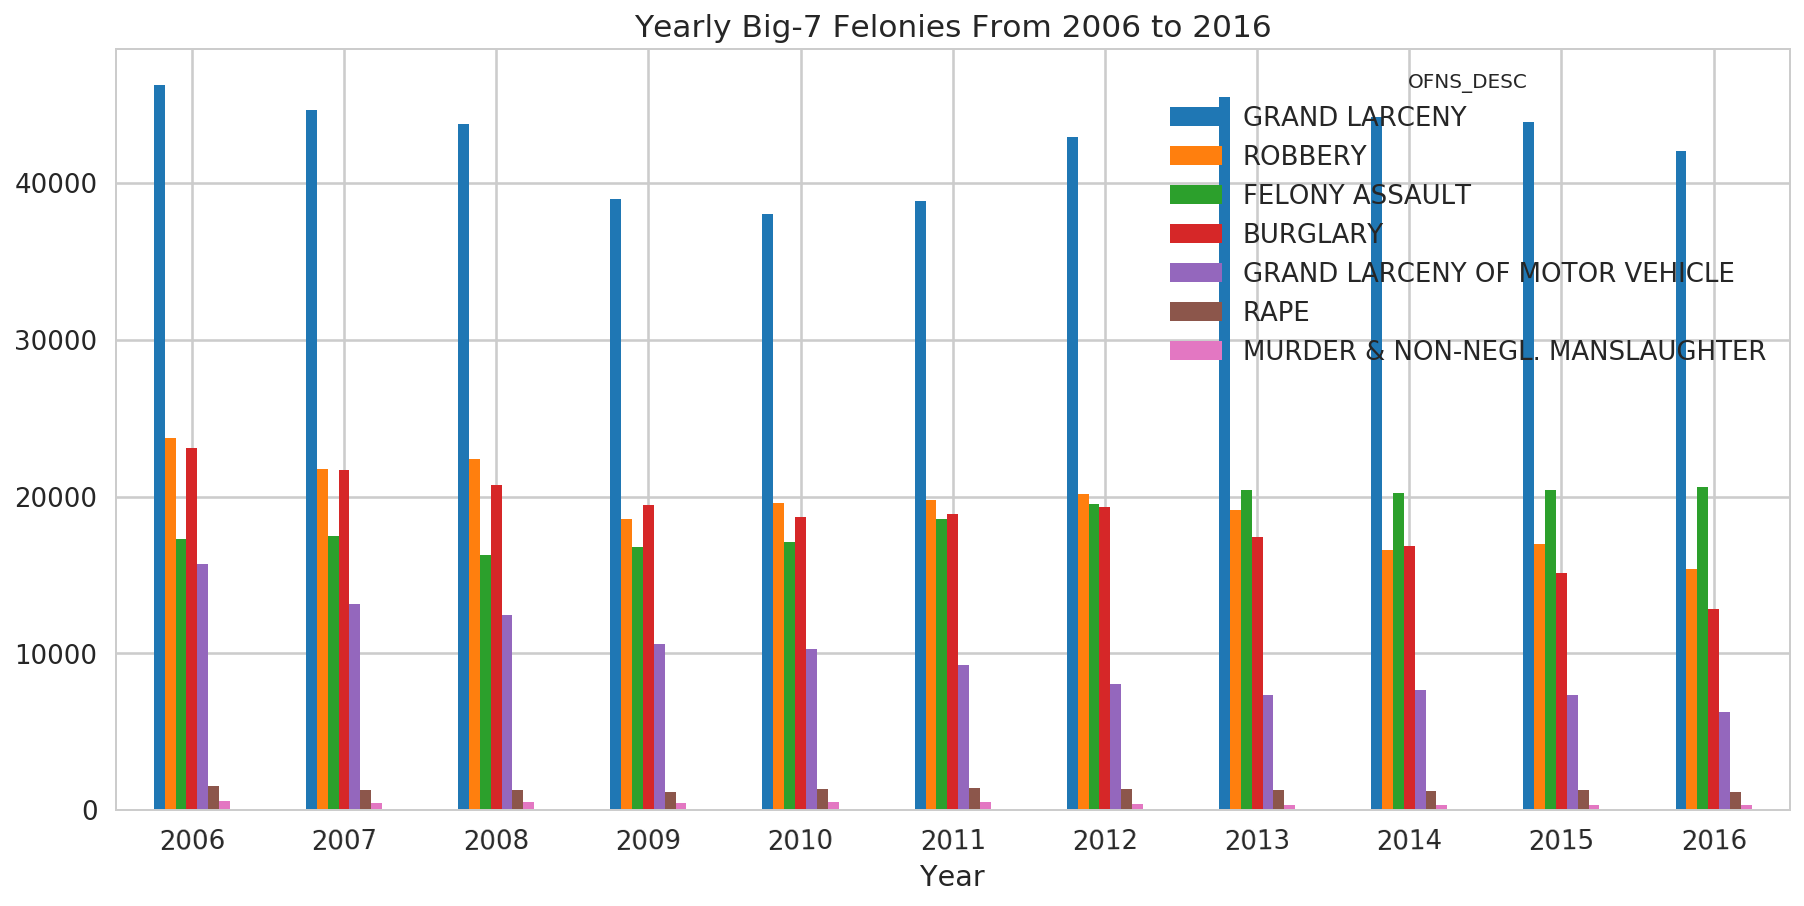

In [13]:
# Question 3b: Plot of big-7 felonies over time, yearly numbers
query = '''
SELECT YEAR(CMPLNT_FR) AS Year,OFNS_DESC, COUNT(*) AS Crime_Count
FROM nypd
WHERE CMPLNT_FR > "2006-01-01"
  AND CMPLNT_FR < "2016-12-31"
  AND OFNS_DESC IN ("GRAND LARCENY","ROBBERY","FELONY ASSAULT","BURGLARY","GRAND LARCENY OF MOTOR VEHICLE","RAPE","MURDER & NON-NEGL. MANSLAUGHTER")
GROUP BY Year, OFNS_DESC
ORDER BY Year
'''

df = pd.read_sql(query,con=engine)
df.OFNS_DESC = pd.Categorical(df.OFNS_DESC,
    categories = ["GRAND LARCENY","ROBBERY","FELONY ASSAULT","BURGLARY","GRAND LARCENY OF MOTOR VEHICLE","RAPE","MURDER & NON-NEGL. MANSLAUGHTER"], 
    ordered=True
)

dfp = pd.pivot_table(
    data = df, 
    index='Year', 
    columns='OFNS_DESC', 
    values='Crime_Count', 
    aggfunc='sum'
)
dfp.plot(kind="bar",rot=True,title="Yearly Big-7 Felonies From 2006 to 2016")

## Question 4: Analyze the Big-7 felonies based on hour of the day.

You are now asked to break down the different big-7 felonies hour of day.

* **Question 4a**: Show the number of big-7 felonies, broken down by hour of day. (e.g., _6049 reported robberies at 5am_). Generate a plot with the results.

* **Question 4b**: Show the number of big-7 felonies, broken down by hour of day. To allow for easier comparison among felonies, **normalize** the data by dividing by the total incidents for each type of felony.  (e.g., _2.8% of the reported robberies happen at 5am_). Generate a bar plot with the results.


**Hint 1**: If you have a datetime column in your dataframe (say `df.CMPLNT_FR`), you can extract the day of the week and the hour, using the following commands. These commands will create two new columns, `DAY_OF_WEEK` and `HOUR`. The `DAY_OF_WEEK` is encoded as a *ordered* categorical variable, in order to sort properly. The `HOUR` is a numeric variable. 

```python
    categs = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df['DAY_OF_WEEK'] = pd.Categorical(df.CMPLNT_FR.dt.weekday_name, categories = categs, ordered=True)
    df['HOUR'] = df.CMPLNT_FR.dt.hour
```

Alternatively, you can use the commands `HOUR()` and `DAYOFWEEK()` in SQL, to extract these values. Note that you do not really need the `DAY_OF_WEEK` part for this question but it can be helpful for other analyses. 

**Hint 2**: When creating plots, you may prefer to put the plot for each columns of the dataframe in a separate plot. The option `subplots=True` for the `df.plot()` command provides that capability. (See [the related documentation](https://pandas.pydata.org/pandas-docs/stable/visualization.html#subplots).) If you use the `subplots=True`, you can also use the `layout=(num_rows, num_columns)` option to specify the number of rows (`num_rows`) and the number of columns (`num_columns`) to use for the grid arrangement.

**Hint 3**: The normalizing data and when generating plots, you may find the `.T` command very handy (shorthand for `.transpose()`). The `.T` command returns the transpose of the dataframe, i.e., returns a dataframe where the columns become rows and vice versa. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f234550db00>,
      dtype=object)

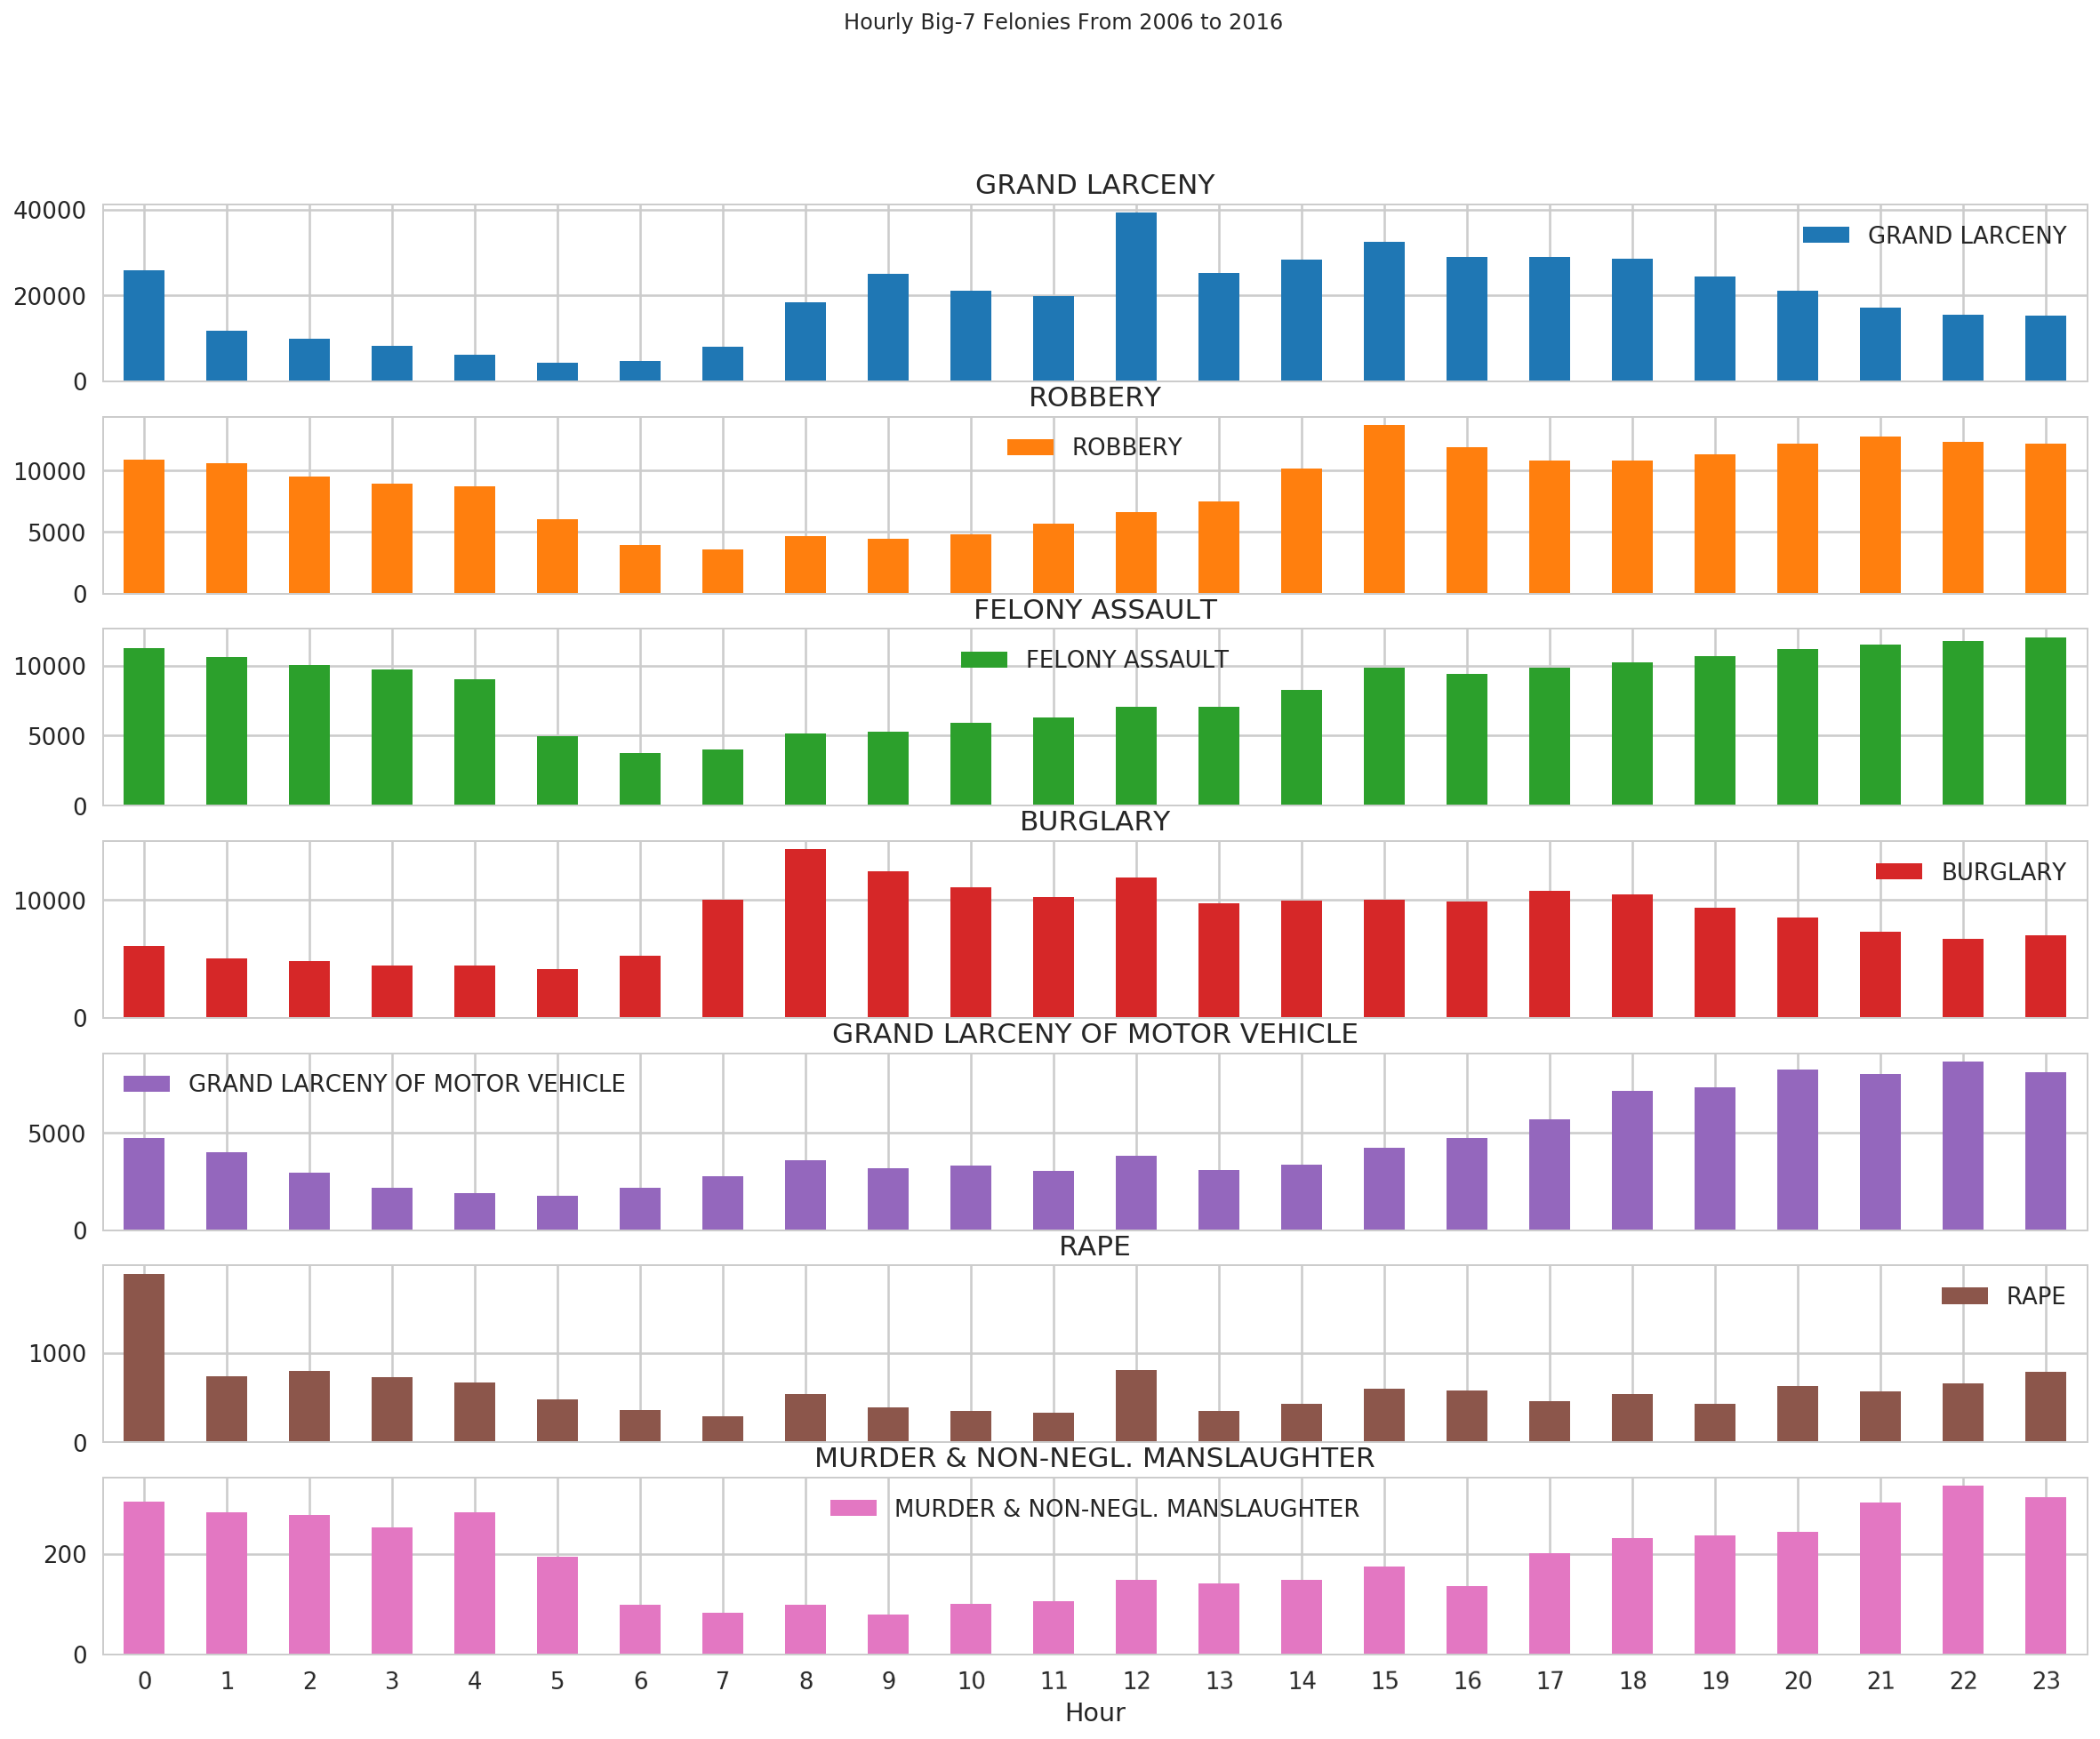

In [14]:
# Question 4a: Show the number of big-7 felonies, broken down by hour of day. (e.g., 6049 reported robberies at 5am). 
# Generate a bar plot with the results.
query = '''
SELECT HOUR(CMPLNT_FR) AS Hour,OFNS_DESC, COUNT(*) AS Crime_Count
FROM nypd
WHERE CMPLNT_FR > "2006-01-01"
  AND CMPLNT_FR < "2016-12-31"
  AND OFNS_DESC IN ("GRAND LARCENY","ROBBERY","FELONY ASSAULT","BURGLARY","GRAND LARCENY OF MOTOR VEHICLE","RAPE","MURDER & NON-NEGL. MANSLAUGHTER")
GROUP BY Hour, OFNS_DESC
ORDER BY Hour
'''

df = pd.read_sql(query,con=engine)
df.OFNS_DESC = pd.Categorical(df.OFNS_DESC,
    categories = ["GRAND LARCENY","ROBBERY","FELONY ASSAULT","BURGLARY","GRAND LARCENY OF MOTOR VEHICLE","RAPE","MURDER & NON-NEGL. MANSLAUGHTER"], 
    ordered=True
)

dfp = pd.pivot_table(
    data = df, 
    index='Hour', 
    columns='OFNS_DESC', 
    values='Crime_Count', 
    aggfunc='sum'
)
dfp.plot(kind="bar",rot=True,title="Hourly Big-7 Felonies From 2006 to 2016",subplots=True,figsize=(20,15))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f234527b3c8>,
      dtype=object)

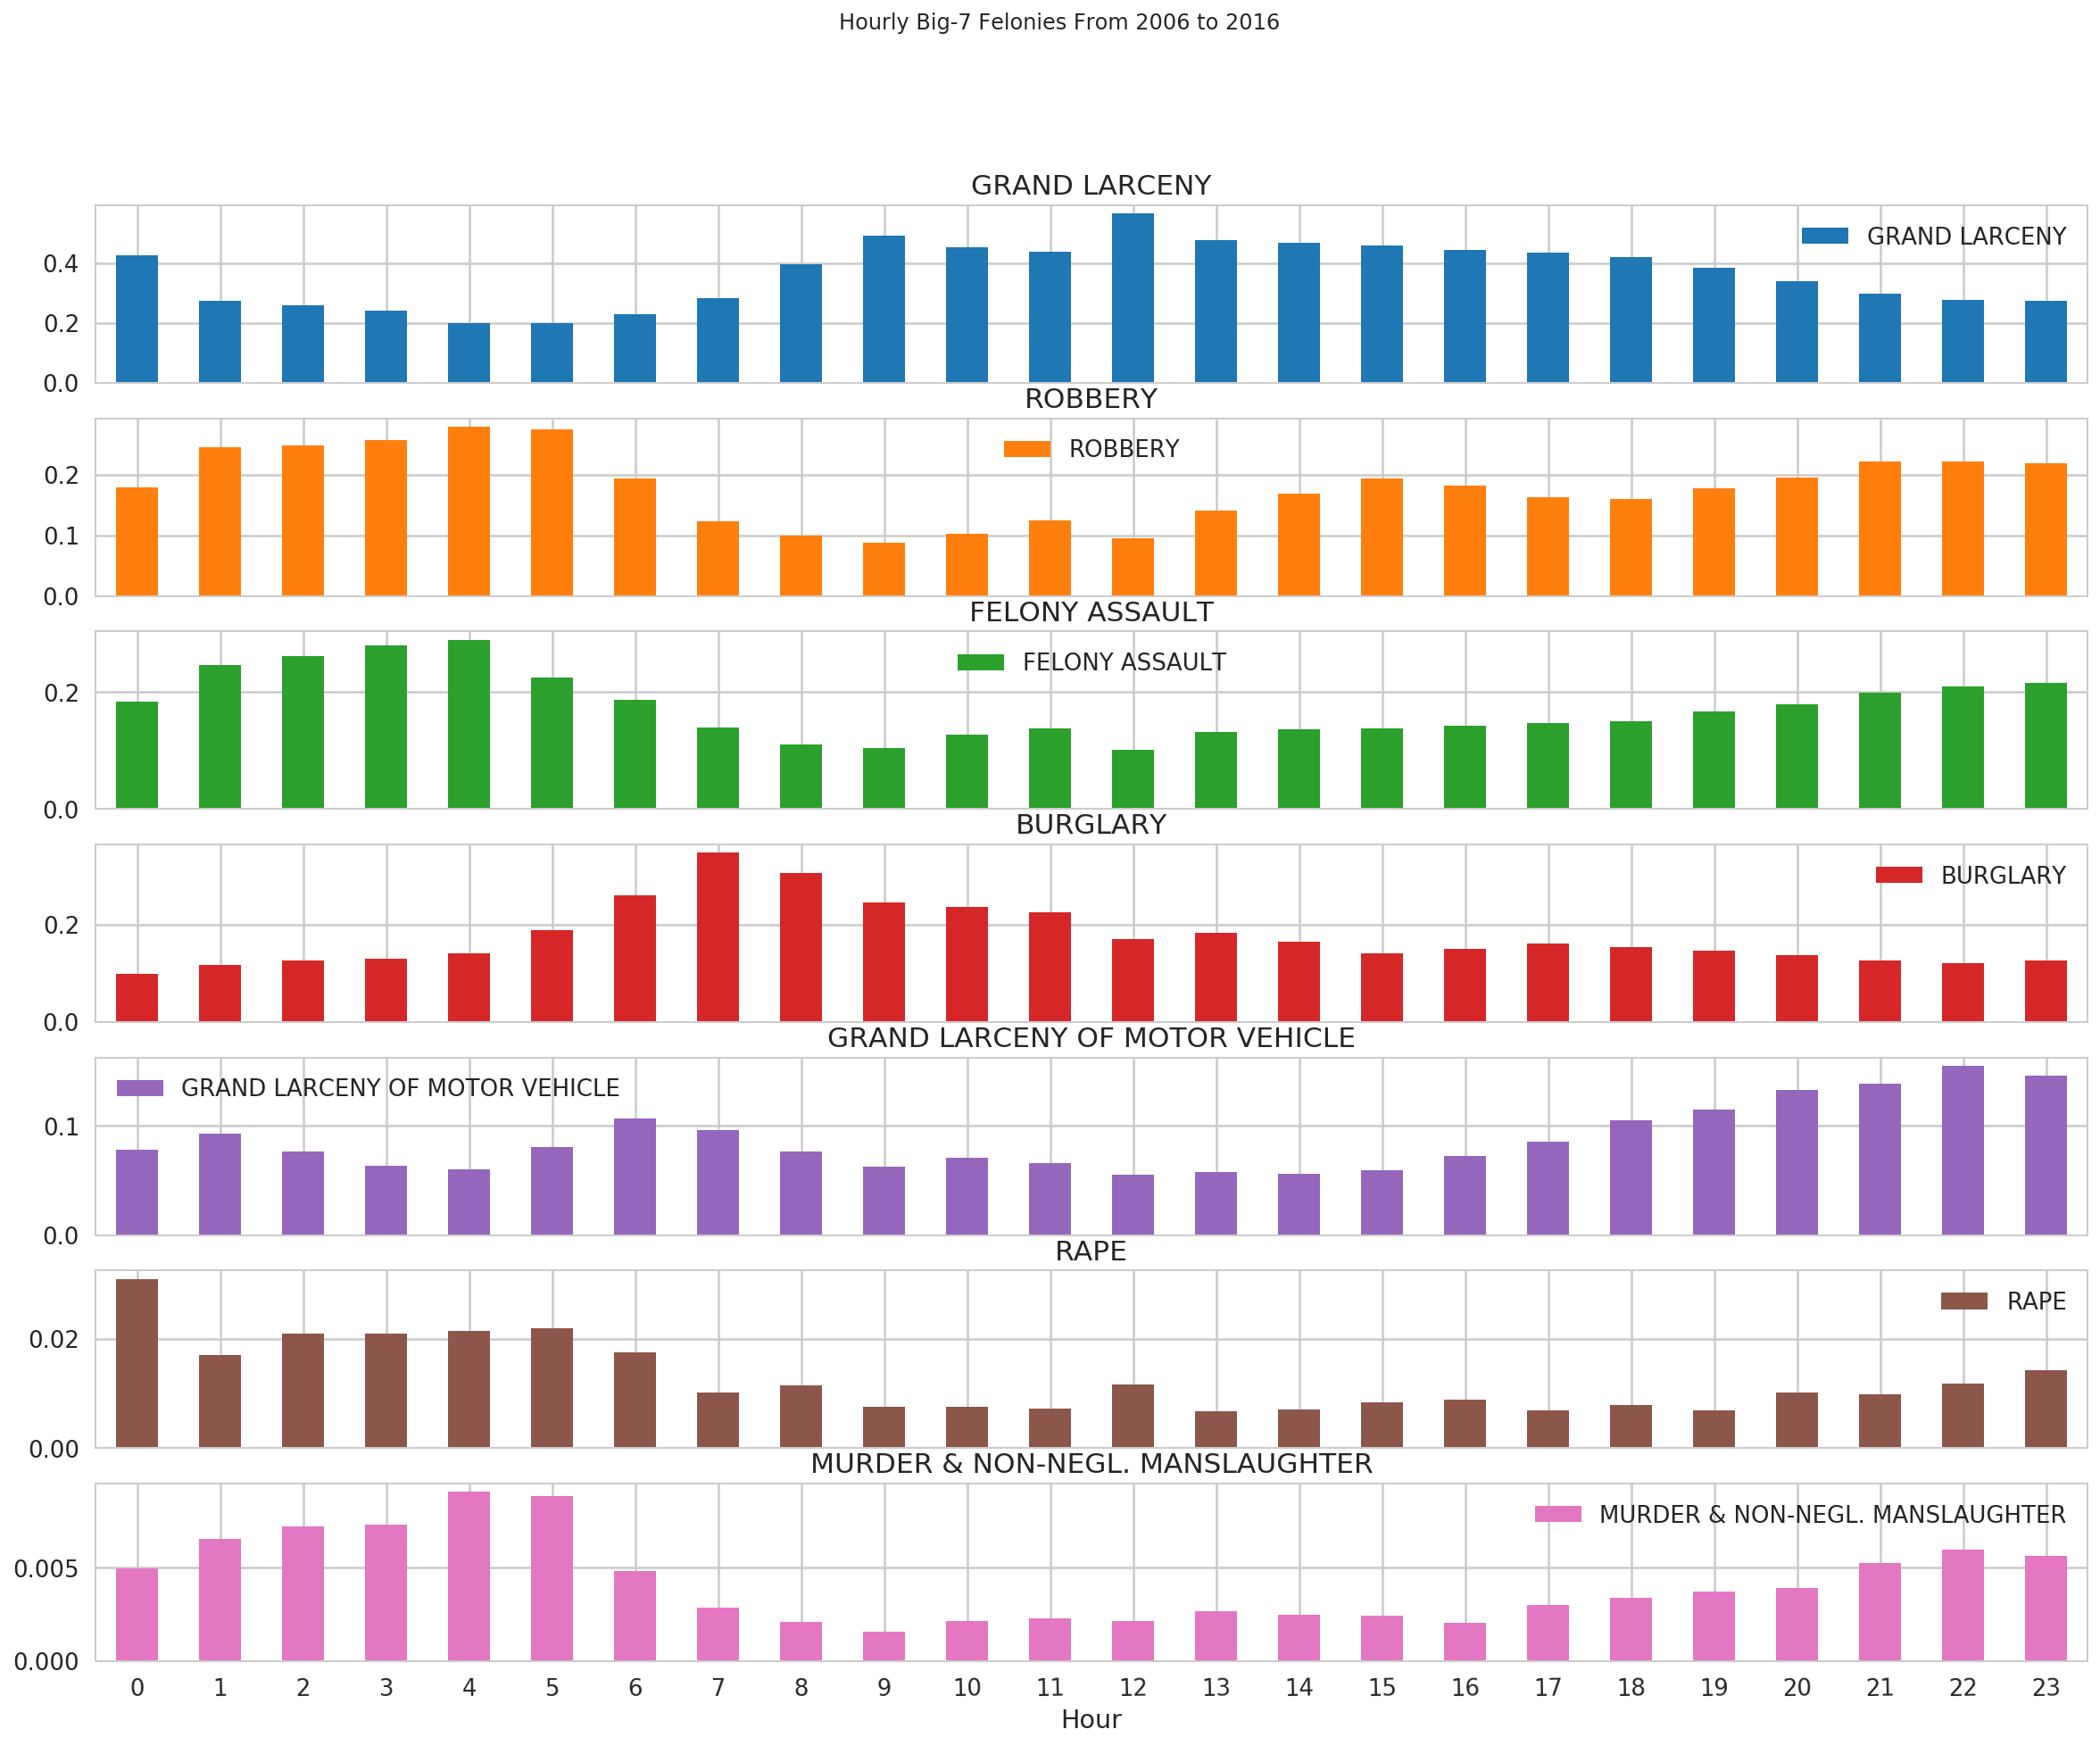

In [15]:
# Question 4b: Show the number of big-7 felonies, broken down by hour of day.
# To allow for easier comparison among felonies, normalize the data by dividing
# by the total incidents for each type of felony. (e.g., 2.8% of the reported robberies happen at 5am).
# Generate a bar plot with the results.
dfp_norm = dfp.div( dfp.sum(axis='columns'), axis='index' )
dfp_norm.plot(kind="bar",rot=True,title="Hourly Big-7 Felonies From 2006 to 2016",subplots=True,figsize=(20,15))

## Question 5: Spatial Analysis

You are asked to analyze the spatial density for the following types of felonies:
* GRAND LARCENY
* GRAND LARCENY OF MOTOR VEHICLE
* FELONY ASSAULT
* MURDER & NON-NEGL. MANSLAUGHTER

Use the `Latitude` and `Longitude` variables from the dataset to identify the location of each crime. (FYI, for victim privacy, the reported rapes do not have geocoding variables associated with them.) Limit your analysis to Manhattan only (see the `BORO_NM` attribute), felonies, and to dates between 2006 and 2016 (inclusive on both ends).

Your goal is to generate four 2d density plots, one for each of the four types of felonies reported above.

**Hint 1**: Remember that if you do a 2d density estimation, you can speed up the computation by taking just a sample of the data that you analyze using the `dataframe.sample()` command.

**Hint 2**: If you could like to plot a map of Manhttan under your density plot, you can use the shapefile of NYC neighborhoods from NYC Open Data, and keep only Manhattan neighborhoods. See the code below. 

In [16]:
# Dataset from NYC Open Data: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq
!curl 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON' -o nyc-neighborhoods.geojson

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4067k    0 4067k    0     0  5665k      0 --:--:-- --:--:-- --:--:-- 5657k


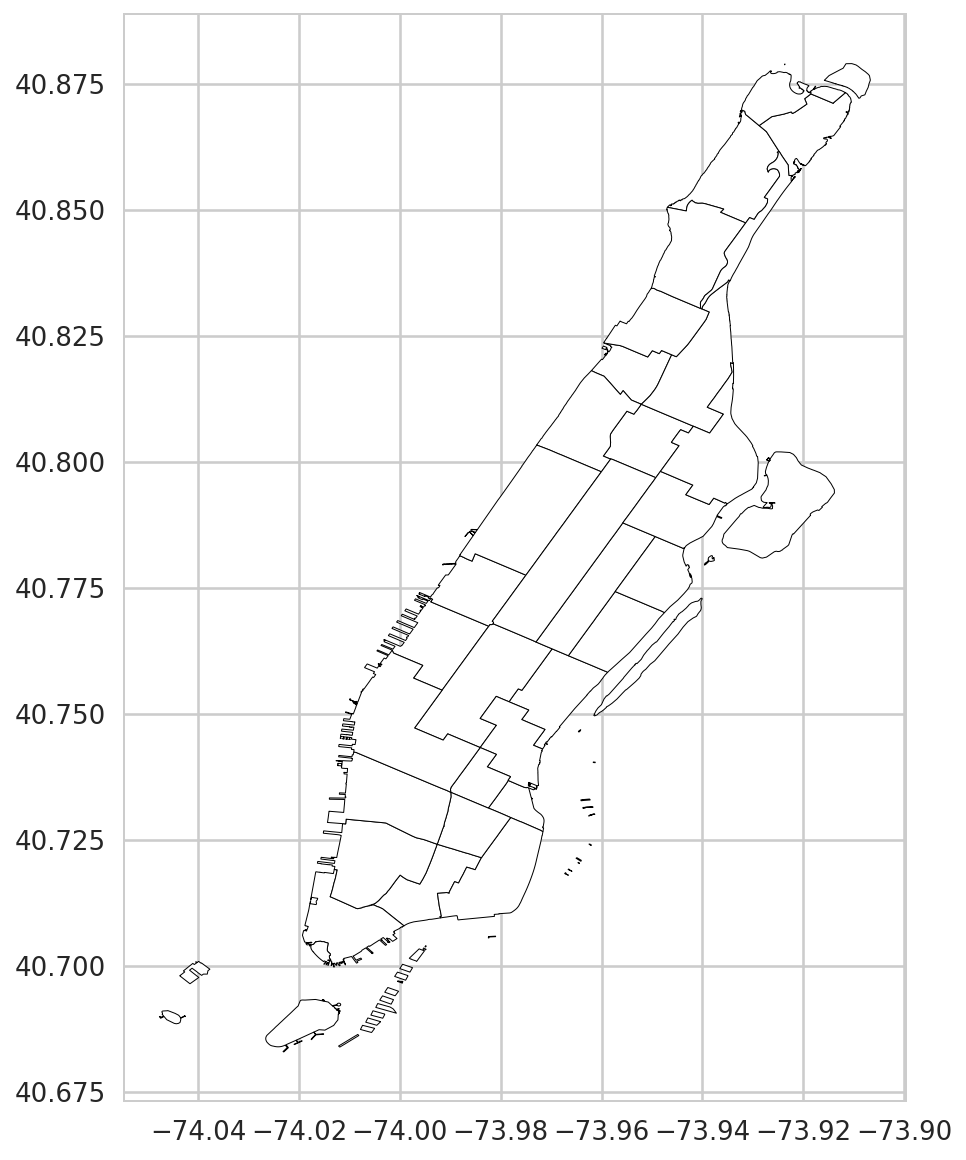

In [17]:
# Load the shapefile
df_nyc = gpd.GeoDataFrame.from_file('nyc-neighborhoods.geojson')
# Limit the data to only Manhattan neighborhoods 
df_manhattan = df_nyc[df_nyc.boro_name =='Manhattan']
# Create a plot
manhattan_plot = df_manhattan.plot(linewidth=0.5, color='White', edgecolor='Black', figsize=(15, 10))

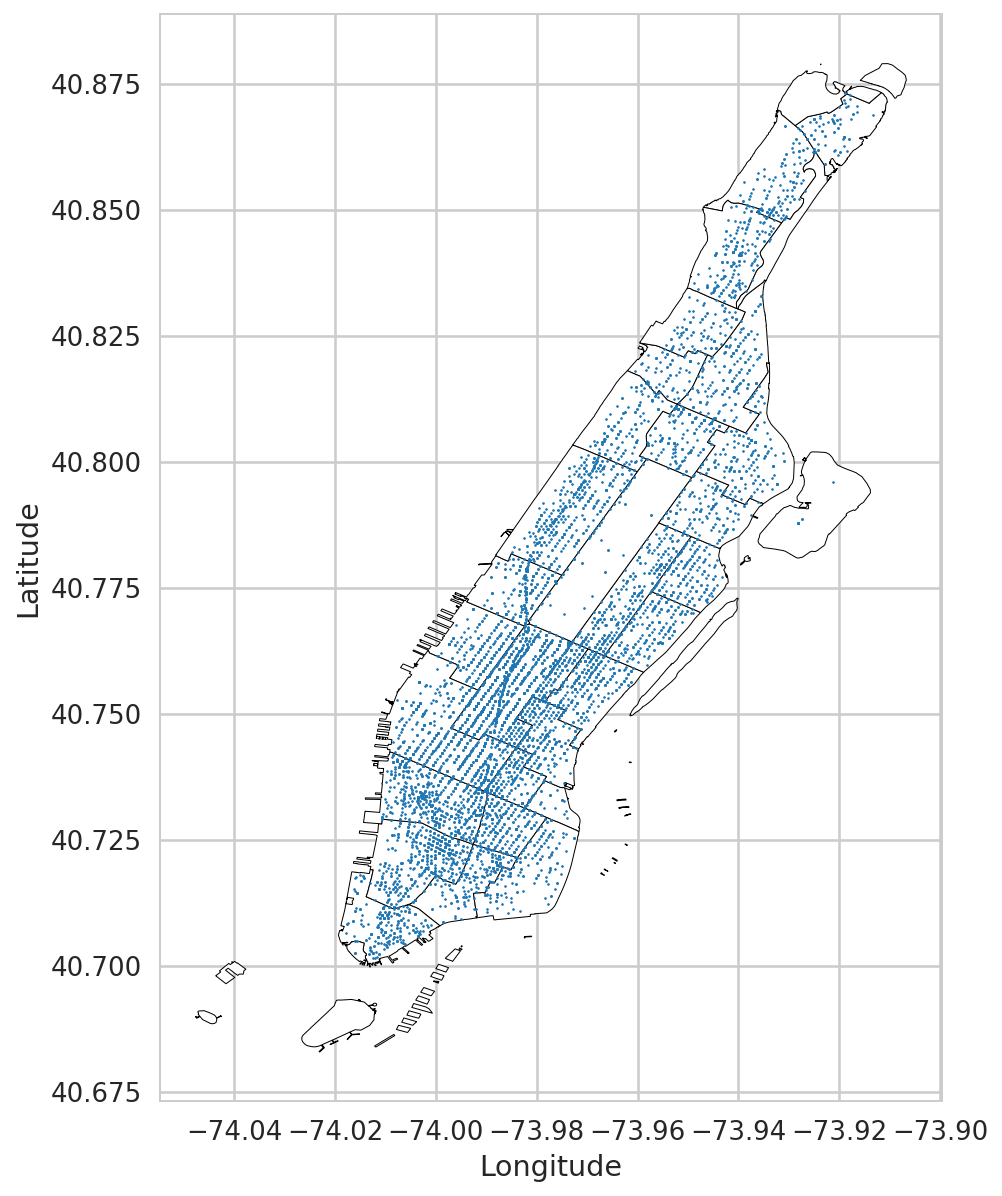

In [18]:
# Density plot: GRAND LARCENY
query = '''
SELECT Latitude,Longitude
FROM nypd
WHERE CMPLNT_FR > "2006-01-01"
  AND CMPLNT_FR < "2016-12-31"
  AND OFNS_DESC LIKE "GRAND LARCENY"
  AND BORO_NM LIKE "MANHATTAN"
'''
df_grand = pd.read_sql(query,con=engine)

df_grand = df_grand.sample(10000)
manhattan_plot = df_manhattan.plot(linewidth=0.5, color='White', edgecolor='Black', figsize=(15, 10))
df_grand.plot(
    kind='scatter',
    x='Longitude', y='Latitude',
    s=0.8, alpha=1,
    figsize=(15, 10),
    ax=manhattan_plot
)

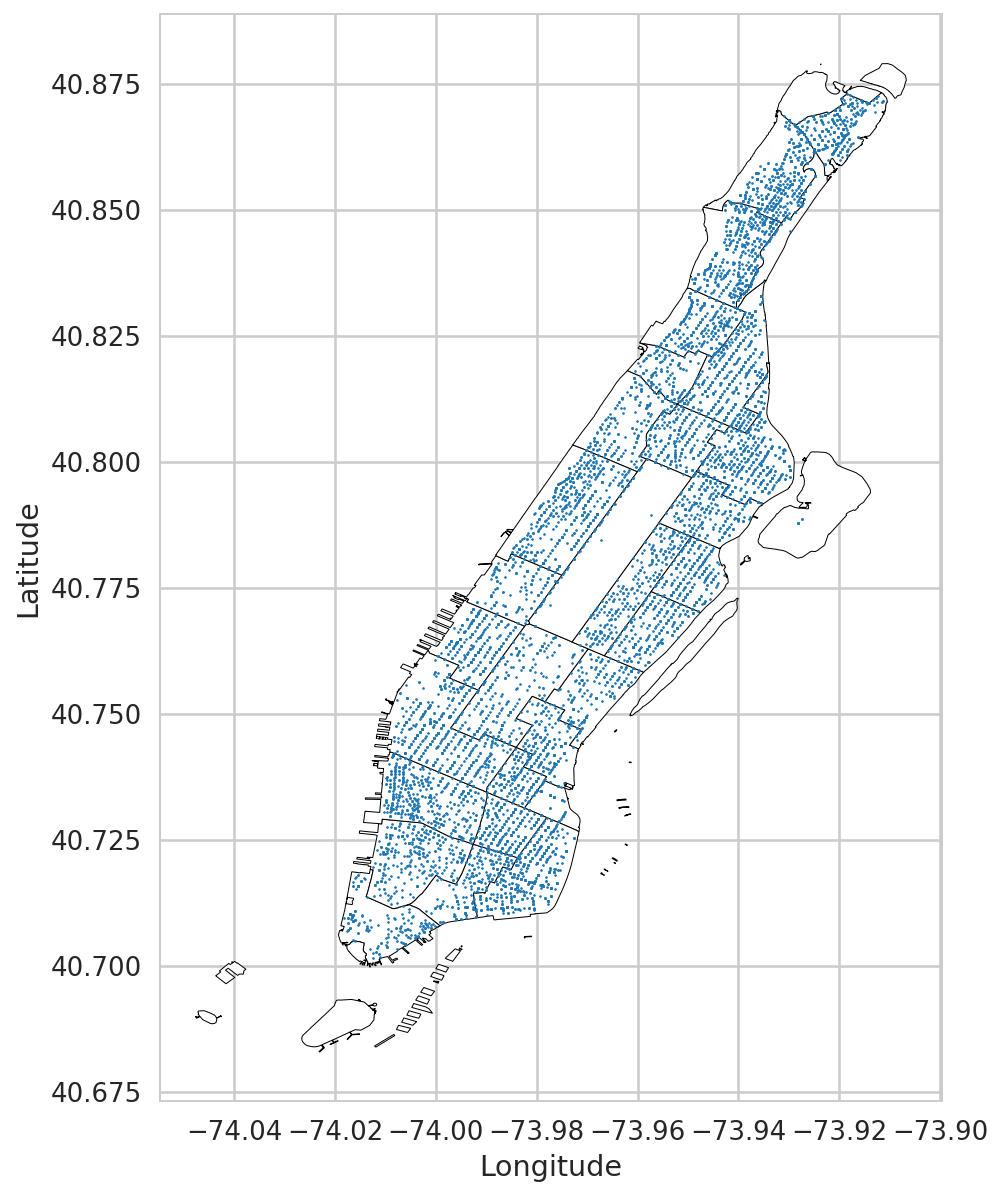

In [19]:
# Density plot: GRAND LARCENY OF MOTOR VEHICLE
query = '''
SELECT Latitude,Longitude
FROM nypd
WHERE CMPLNT_FR > "2006-01-01"
  AND CMPLNT_FR < "2016-12-31"
  AND OFNS_DESC LIKE "GRAND LARCENY OF MOTOR VEHICLE"
  AND BORO_NM LIKE "MANHATTAN"
'''
df_grand = pd.read_sql(query,con=engine)

df_grand = df_grand.sample(10000)
manhattan_plot = df_manhattan.plot(linewidth=0.5, color='White', edgecolor='Black', figsize=(15, 10))
df_grand.plot(
    kind='scatter',
    x='Longitude', y='Latitude',
    s=0.8, alpha=1,
    figsize=(15, 10),
    ax=manhattan_plot
)

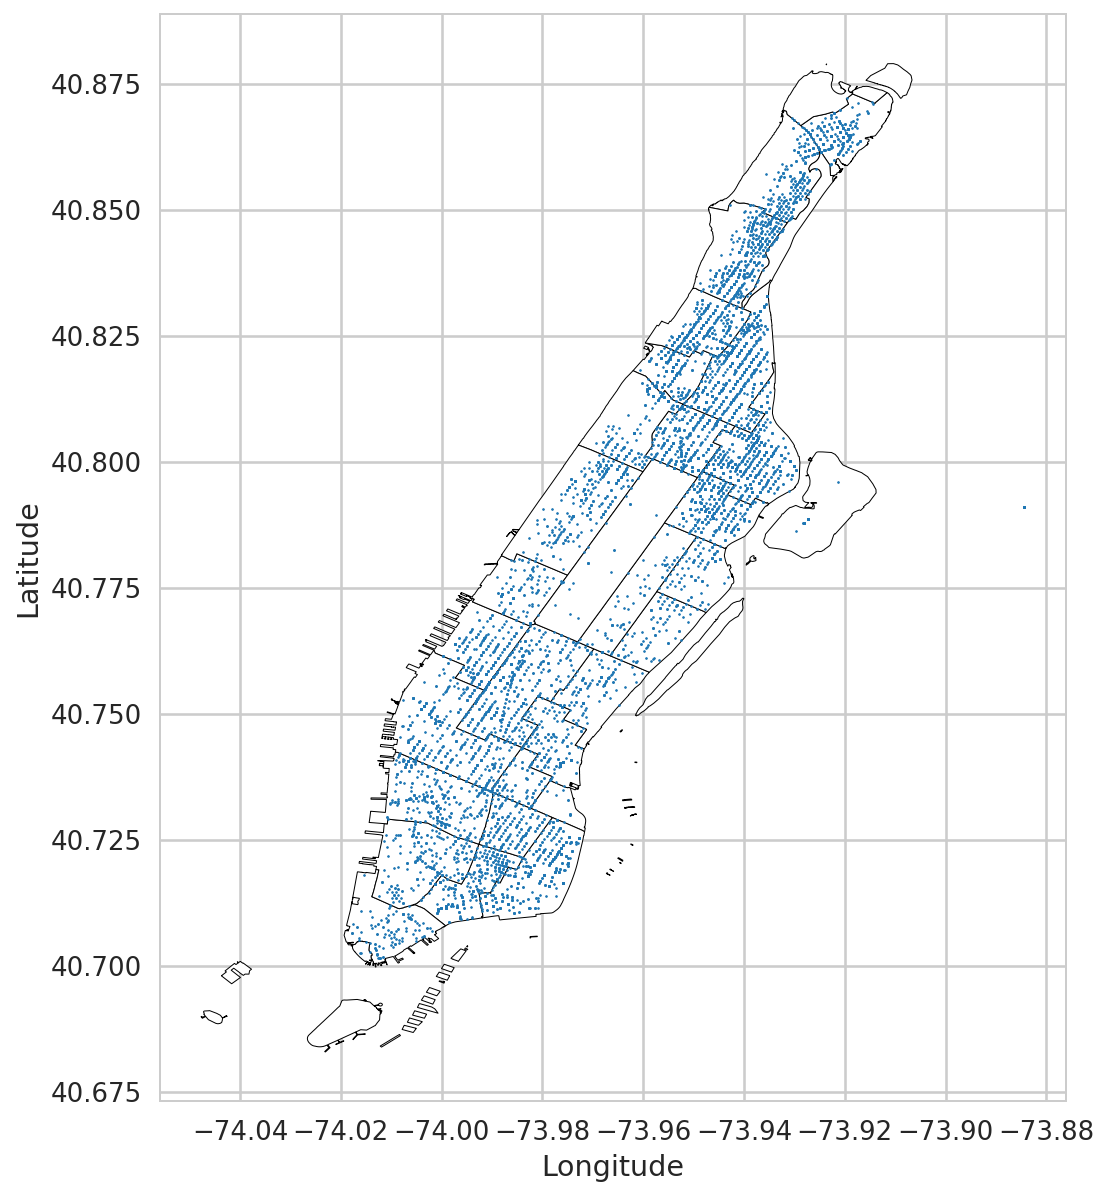

In [20]:
# Density plot: FELONY ASSAULT
query = '''
SELECT Latitude,Longitude
FROM nypd
WHERE CMPLNT_FR > "2006-01-01"
  AND CMPLNT_FR < "2016-12-31"
  AND OFNS_DESC LIKE "FELONY ASSAULT"
  AND BORO_NM LIKE "MANHATTAN"
'''
df_felony = pd.read_sql(query,con=engine)

df_felony = df_felony.sample(10000)
manhattan_plot = df_manhattan.plot(linewidth=0.5, color='White', edgecolor='Black', figsize=(15, 10))
df_felony.plot(
    kind='scatter',
    x='Longitude', y='Latitude',
    s=0.8, alpha=1,
    figsize=(15, 10),
    ax=manhattan_plot
)


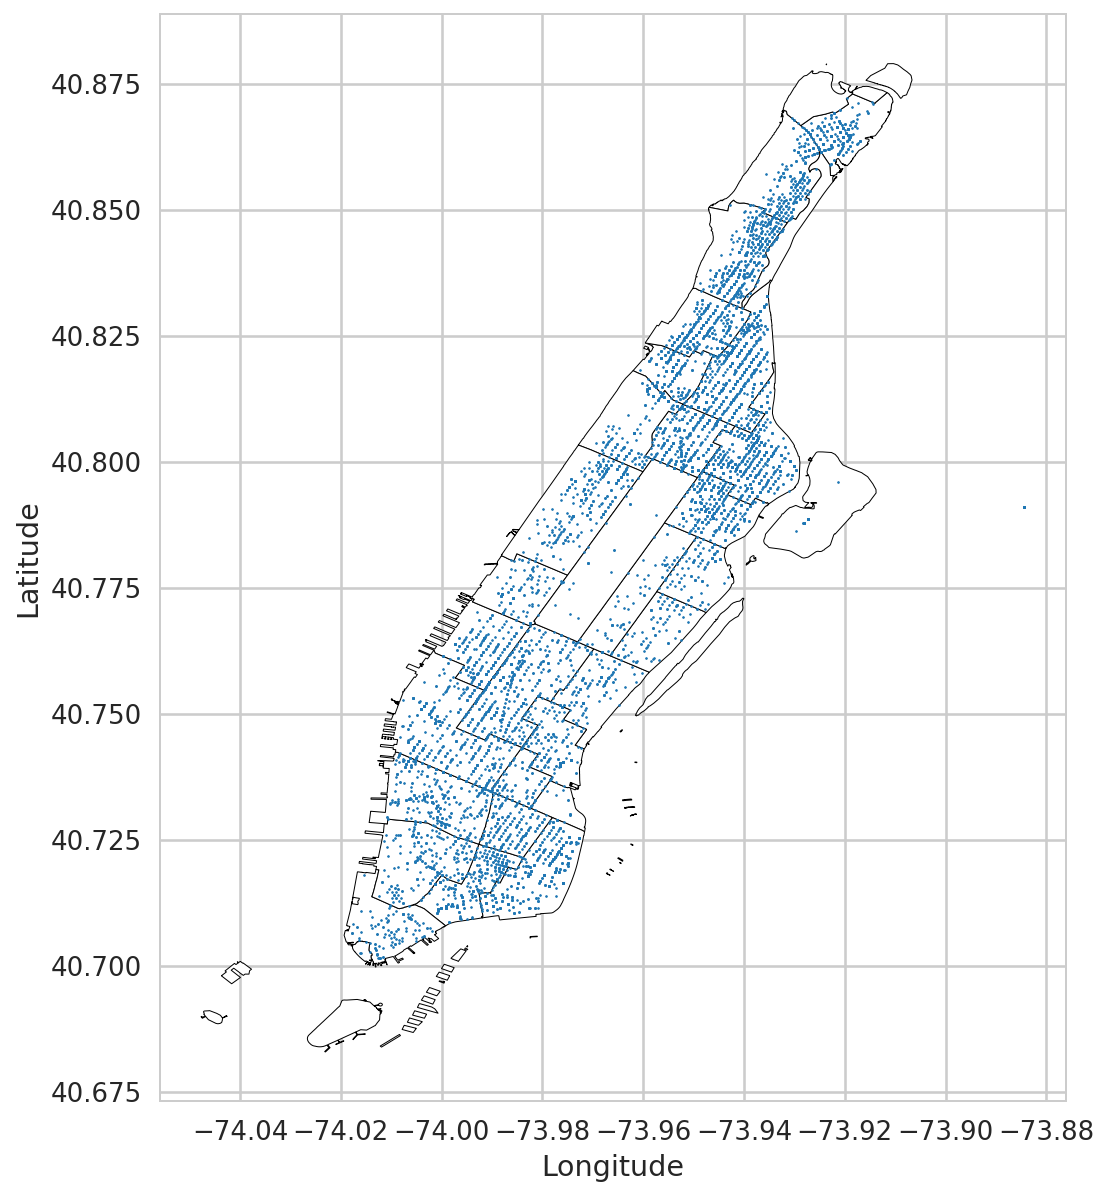

In [21]:
# Density plot: MURDER & NON-NEGL. MANSLAUGHTER
query = '''
SELECT Latitude,Longitude
FROM nypd
WHERE CMPLNT_FR > "2006-01-01"
  AND CMPLNT_FR < "2016-12-31"
  AND OFNS_DESC LIKE "MURDER & NON-NEGL. MANSLAUGHTER"
  AND BORO_NM LIKE "MANHATTAN"
'''
df_murder = pd.read_sql(query,con=engine)

df_murder = df_felony.sample(10000)
manhattan_plot = df_manhattan.plot(linewidth=0.5, color='White', edgecolor='Black', figsize=(15, 10))
df_murder.plot(
    kind='scatter',
    x='Longitude', y='Latitude',
    s=0.8, alpha=1,
    figsize=(15, 10),
    ax=manhattan_plot
)